# Clustering de Imágenes de Perros y Gatos


# Presentación y referencias

Para el entrenamiento de un modelo de machine learning existen diferentes técnicas aplicables según los datos que se posean, siendo la forma más común de entrenamiento aquella supervisada, en que explícitamente se indíca a qué grupo o etiqueta pertenece un dato para que el modelo aprenda. Sin embargo, este tipo de entrenamiento puede ser no aplicable si, por ejemplo, el conjunto de datos no posee etiquetas explícitas o se desean analizar tendencias en datos recopilados, siendo necesario para estos casos el uso de metodologías como clustering: entregar el conjunto a un algoritmo que sea capaz de identificar similitudes entre los diferentes puntos y asignarlos a grupos según estén más cerca unos de otros.

A modo de ejemplo inicial se utilizará el caso más simple: Clasificar una imagen según su contenido, indicando si en esta se aprecia un perro o un gato, utilizando datos no etiquetados para realizar el entrenamiento.

## Referencias
- Definición: https://developers.google.com/machine-learning/clustering/overview
- Dataset: https://www.kaggle.com/datasets/chetankv/dogs-cats-images

# Problema
Se posee un conjunto de datos compuesto por imágenes que muestran perros o gatos, inicialmente separadas para uso en entrenamiento supervisado. Se desea utilizar estas imágenes para el entrenamiento y validación de modelos de aprendizaje utilizando diferentes técnicas de clustering para distinguir los diferentes juegos.

Para ello, será necesario:
1. Reunir las imágenes bajo una sola carpeta, esto a fin de simular el tipo de entrenamiento sin etiquetas. Para fines de aprendizaje se mantendrán indicadores como nombre de archivo para saber a qué juego pertenece una imagen, pero esto no será utilizado en el proceso de entrenamiento.
2. Analizar el set de datos, separando imágenes de entrenamiento y de prueba del modelo.
3. Transformar las imágenes: Una imagen no puede ser directamente utilizada para entrenar un modelo, por lo que se requiere de una conversión especial a valores utilizables.
4. Entrenar modelo.
5. Comprobar métricas de modelo entrenado.

## EDA
Para comenzar con el proceso se debe, inicialmente, conocer el set de datos con el que se trabaja. Para ello, se comenzará importando los archivos a utilizar y a visualizarlos.

Inicialmente se lee el directorio del dataset

In [1]:
import os
os.chdir("../../data")

In [2]:
import os
import os
folder = "catsdogs"
file_paths=[]



for root, _, files in os.walk(folder):
    
    for file_path in files:
        if file_path.endswith((".png", ".jpg")):
            path = os.path.join(root, file_path)
            file_paths.append(path)


len(file_paths)

4000

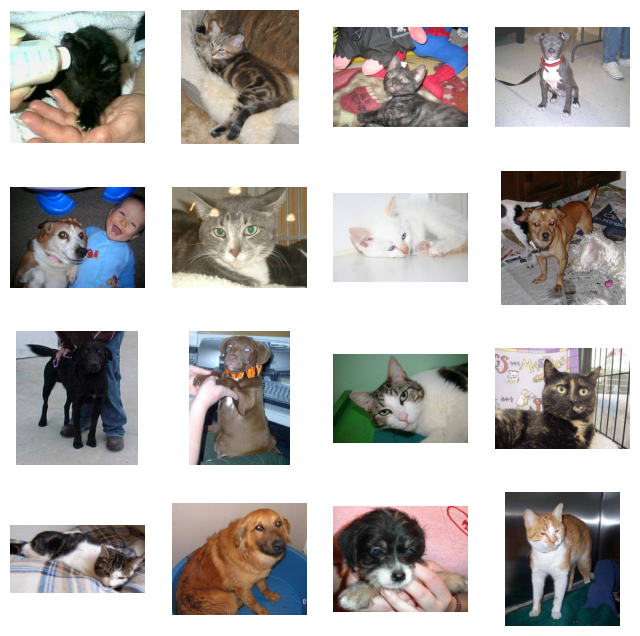

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_samples(image_paths, n=9):
    idx = np.random.choice(len(image_paths), n, replace=False)
    plt.figure(figsize=(8, 8))
    for i, i_img in enumerate(idx):
        image_path=image_paths[i_img]
        img = np.array(Image.open(image_path).convert("RGB"))
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
        plt.imshow(img.astype("uint8"))
        plt.axis("off")
    plt.show()

# Example usage
show_samples(file_paths,16)

## Separación de entrenamiento y de prueba
Para separar datos para el entranamiento del modelo y de prueba se puede utilizar la herramienta split de sklearn.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test= train_test_split(
file_paths, test_size=0.2, random_state=42)

## Embedding
Las imágenes por sí solas, a pesar de que son significativas para un humano, no pueden ser utilizadas para entrenamiento. El análisis pixel a pixel no es efectivo para el aprendizaje, por lo que se utilizan técnicas como el **embedding**: pasar la imagen por un modelo especializado capaz de extraer información vectorial de la imagen que podrá ser utilizada para entrenar. 

En este ejemplo se utilizará ResNet para realizar el embedding, su calidad no es la más óptima pero es más rápida que otras opciones.

In [5]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os

In [6]:
resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove classifier
resnet.eval()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:13<00:00, 3.36MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [7]:
# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [8]:
def get_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        vec = resnet(tensor).squeeze().numpy()
    return vec

In [9]:

embeddings = []


for file_path in X_train:
    if file_path.endswith((".jpg", ".png")):
        embeddings.append(get_embedding(file_path))

In [10]:
embeddings = np.stack(embeddings)

In [11]:
embeddings[0]

array([0.6660489 , 1.5067581 , 1.1720809 , 0.09928348, 0.7595414 ,
       0.52907336, 0.37680218, 0.5935011 , 0.58511853, 0.8478365 ,
       1.2040572 , 0.550779  , 0.45986047, 0.19756901, 1.0678542 ,
       0.42736164, 1.9162145 , 0.18455608, 0.47536117, 2.3373675 ,
       0.9427633 , 1.1693491 , 1.06395   , 0.42626452, 1.819908  ,
       0.13539681, 0.10944423, 0.65889055, 0.34319258, 0.28679922,
       0.5872875 , 0.10163988, 0.33503887, 0.4189431 , 0.23393974,
       0.3489316 , 1.5463887 , 0.18802086, 1.3280172 , 0.9044388 ,
       0.2562643 , 0.26561958, 1.17356   , 0.2954022 , 0.6090607 ,
       1.0685513 , 1.9374801 , 2.5542696 , 0.0275197 , 0.02786867,
       0.25204724, 0.7856859 , 0.33865938, 0.5218359 , 0.73317444,
       0.2737378 , 0.88183576, 0.3833527 , 0.15546873, 0.5117959 ,
       1.6380799 , 1.6180423 , 0.31539845, 0.31592804, 1.022187  ,
       0.995148  , 1.0019306 , 3.4380617 , 0.6595206 , 0.38407055,
       0.23631021, 0.11156777, 0.41409844, 0.6694905 , 0.63835

## Entrenar modelo
Para entrenar un modelo existen diferentes algoritmos a utilizar, adaptados a diferentes finalidades. Entre ellos está KMeans, cuyo parámetro principal es la cantidad de clusters a encontrar: a partir de este parámetro intentará, de la forma que sea, encontrar esa N cantidad de clusters que se indique, sean significativos o no. Como en este caso es conocida la cantidad de elementos posibles, perro o gato, N es igual a 2.

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=23)
labels = kmeans.fit_predict(embeddings)

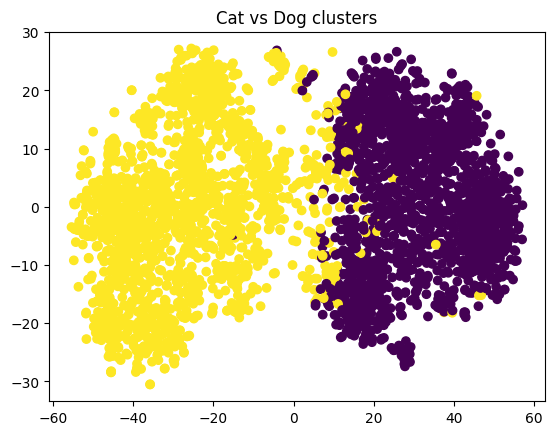

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

proj = TSNE(n_components=2, random_state=23).fit_transform(embeddings)
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='viridis')
plt.title("Cat vs Dog clusters")
plt.show()

In [14]:
for cluster in range(2):
    dogs=0
    cats=0
    print(f"Cluster {cluster}:")
    for file_path, lbl in zip(X_train, labels):
        if lbl == cluster:
            filename=file_path.split("/")[1]
            if "cat" in filename:
                cats+=1
            elif "dog" in filename:
                dogs+=1
    print(f"\t Cats: {cats}")
    print(f"\t Dogs: {dogs} \n")

Cluster 0:
	 Cats: 1473
	 Dogs: 4 

Cluster 1:
	 Cats: 122
	 Dogs: 1601 



# Probar modelo
Se utilizan los elementos del conjunto de pruebas para verificar los resultados obtenidos.

In [15]:

test_embeddings=[]
for file_path in X_test:
    if file_path.endswith((".jpg", ".png",".jpeg")):
        test_embeddings.append(get_embedding(file_path))

testembeddings = np.stack(test_embeddings)

testlabels=kmeans.predict(testembeddings)

In [16]:
for cluster in range(2):
    print(f"Cluster {cluster}:")
    cats=0
    dogs=0
    for file_path, lbl in zip(X_test, testlabels):
        if lbl == cluster:
            if lbl == cluster:
                filename=file_path.split("/")[1]
                if "cat" in filename:
                    cats+=1
                elif "dog" in filename:
                    dogs+=1
    print(f"\t Cats: {cats}")
    print(f"\t Dogs: {dogs} \n")

Cluster 0:
	 Cats: 366
	 Dogs: 0 

Cluster 1:
	 Cats: 39
	 Dogs: 395 



# Guardar modelo
El modelo ya entrenado puede ser guardado y posteriormente cargado mediante estas dos celdas respectivamente.

In [17]:
import joblib
joblib.dump(kmeans, "catsdogs.pkl")

['catsdogs.pkl']

In [18]:
import joblib
kmeans = joblib.load("catsdogs.pkl")